In [36]:
#Load env. secret
import os 
from dotenv import load_dotenv
load_dotenv(os.path.join("secrets.local", ".secrets"))

PWD_MYSQL: str = os.getenv(key="PWD_MYSQL")

# Querying DB

In [ ]:
from mysql import connector

In [37]:
# Establish a connection to the database
cnx = connector.connect(host = "localhost",
        user = "root",
        password = PWD_MYSQL,
        database = "linkedin_data")
cursor = cnx.cursor()

In [38]:
#INVITATIONS

# Query the data from the invitations table
query = """SELECT *
        FROM invitations"""
cursor.execute(query)

# Fetch the results and load into a DataFrame
df_invitations = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

In [39]:
#INBOX

# Query the data from the inbox table
query = """SELECT *
        FROM inbox"""
cursor.execute(query)

# Fetch the results and load into a DataFrame
df_inbox = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

In [40]:
#ALL_LIKES

# Query the data from the all_likes table
query = """SELECT *
        FROM all_likes"""
cursor.execute(query)

# Fetch the results and load into a DataFrame
df_all_likes = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

In [42]:
# Close the cursor and connection
cursor.close()
cnx.close()

# Data Viz

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

#### Inbox

In [57]:
# Week/month conversation start date
df_inbox['date_week'] = df_inbox['datetime_paris'].dt.to_period('W').apply(lambda x: x.start_time)
df_inbox['date_month'] = df_inbox['datetime_paris'].dt.to_period('M').apply(lambda x: x.start_time)

# Column day of week
df_inbox['day_of_week'] = df_inbox['datetime_paris'].dt.day_name()

# Row number to detect the start date of the conversation
df_inbox = df_inbox.sort_values(by=['conversation_id', 'datetime_paris'])
df_inbox['row_number'] = df_inbox.groupby('conversation_id').cumcount() + 1

# Excluding conversations from linkedin marketing solution
filtered_df_inbox = df_inbox[~df_inbox['sender_name'].isin(['LinkedIn Marketing Solutions', 'LinkedIn Premium'])]

# Select first message and date
df_first_message = filtered_df_inbox[filtered_df_inbox['row_number'] == 1]
df_first_message = df_first_message[df_first_message['date_week'] >= '2023-01-01']

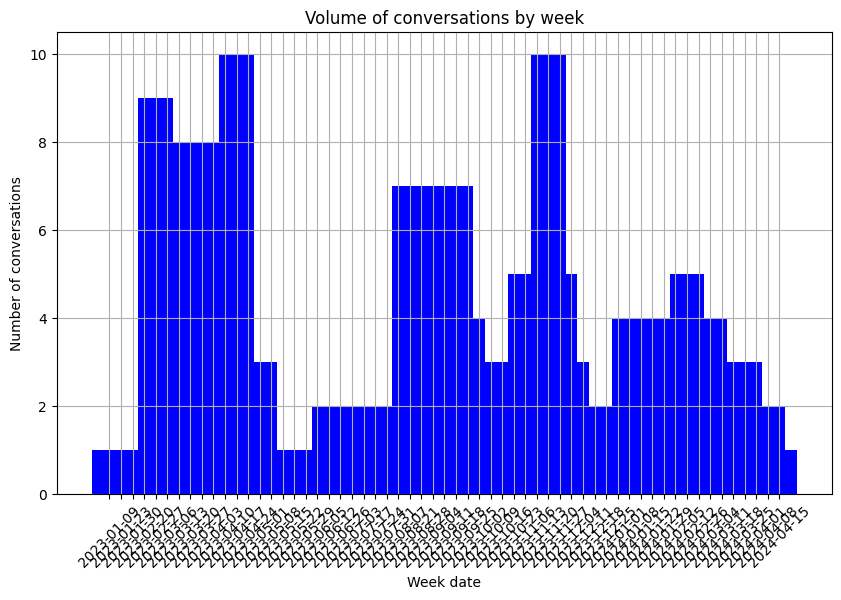

In [71]:
# Conversation volume evolution

# Aggregation by week
df_conv_by_week = df_first_message.groupby(['date_week'], as_index=False, dropna=False).agg({'conversation_id':'nunique'})

#Rename columns
df_conv_by_week.columns = ['date_week', 'conversation_ct']

# Histogram creation
plt.figure(figsize=(10, 6)) 
plt.bar(df_conv_by_week['date_week'].dt.strftime('%Y-%m-%d'), df_conv_by_week['conversation_ct'], color='blue', width=3) 
plt.title('Volume of conversations by week')
plt.xlabel('Week date')
plt.ylabel('Number of conversations')
plt.xticks(rotation=45)
plt.grid(True)  
plt.show() 


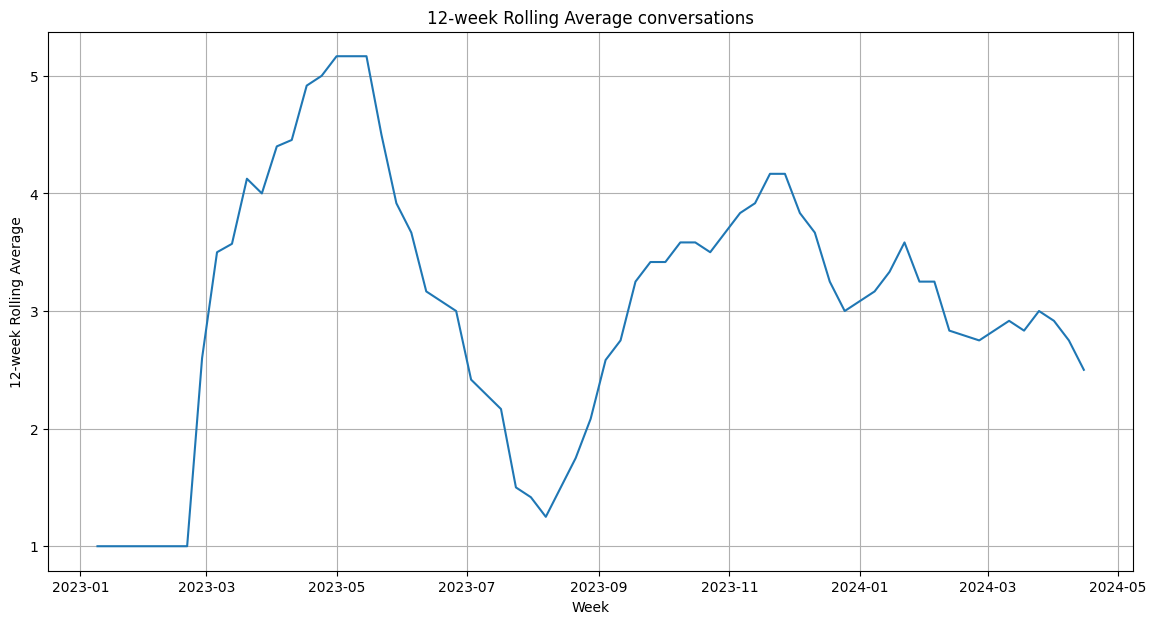

In [81]:
# Rolling 12-week average

# Calculating the rolling 16-week average
df_conv_by_week['rolling_average'] = df_conv_by_week['conversation_ct'].rolling(window=12, min_periods=1).mean()

# Line plot creation
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_conv_by_week, x='date_week', y='rolling_average')
plt.title('12-week Rolling Average conversations')
plt.xlabel('Week')
plt.ylabel('12-week Rolling Average')
plt.grid(True)
plt.show()

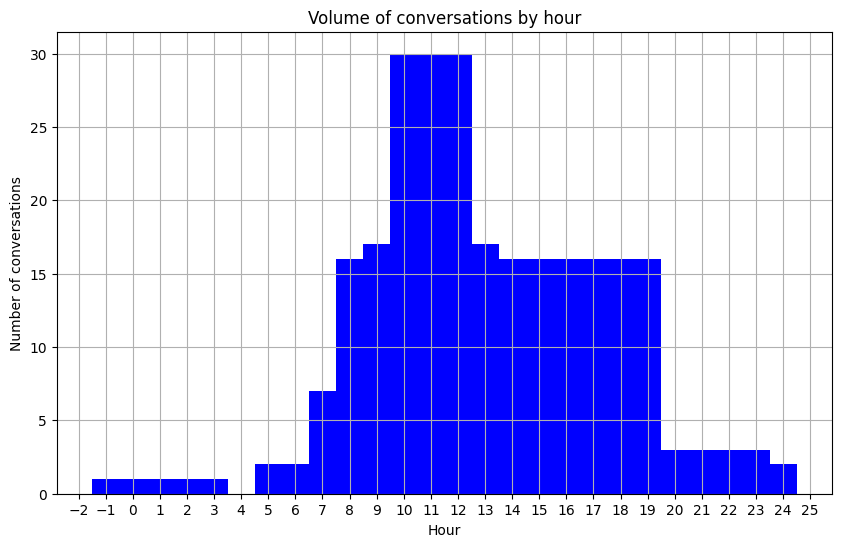

In [72]:
# Distribution of conversations by time of day

# Aggregation by week
df_conv_by_hour = df_first_message.groupby(['hour_paris'], as_index=False, dropna=False).agg({'conversation_id':'nunique'})

#Rename columns
df_conv_by_hour.columns = ['hour', 'conversation_ct']

# Sort values
df_conv_by_hour = df_conv_by_hour.sort_values(by=['hour'])

# Histogram creation
plt.figure(figsize=(10, 6)) 
plt.bar(df_conv_by_hour['hour'], df_conv_by_hour['conversation_ct'], color='blue', width=3)  
plt.gca().xaxis.set_major_locator(MultipleLocator(1)) 
plt.title('Volume of conversations by hour')
plt.xlabel('Hour')
plt.ylabel('Number of conversations')
plt.grid(True)  
plt.show() 



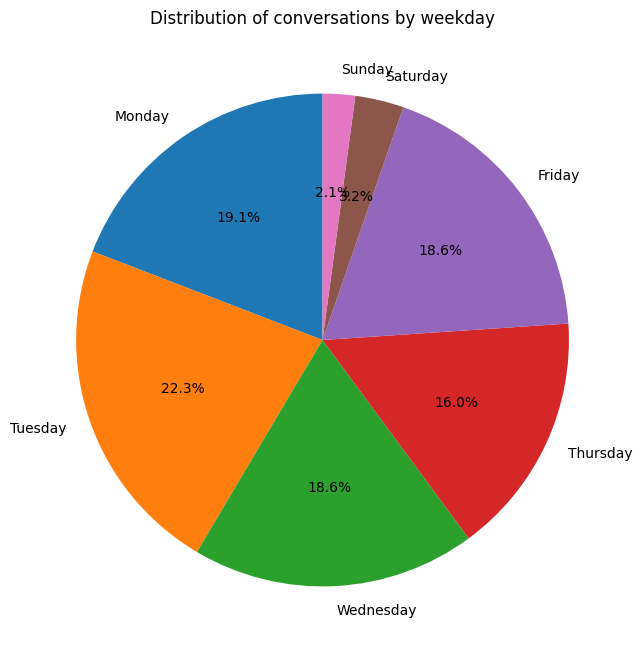

In [78]:
# Distribution of conversations by weekday

# Aggregation by week
df_conv_by_weekday = df_first_message.groupby(['day_of_week'], as_index=False, dropna=False).agg({'conversation_id':'nunique'})

#Rename columns
df_conv_by_weekday.columns = ['day_of_week', 'conversation_ct']

# Define the correct order of the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Rearrange DataFrame according to day order
df_conv_by_weekday['day_of_week'] = pd.Categorical(df_conv_by_weekday['day_of_week'], categories=days_order, ordered=True)
df_conv_by_weekday = df_conv_by_weekday.sort_values('day_of_week')

# Pie chart creation
plt.figure(figsize=(8, 8))  # Définit la taille de la figure
plt.pie(df_conv_by_weekday['conversation_ct'], labels=df_conv_by_weekday['day_of_week'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of conversations by weekday')
plt.show()

#### Invitations

In [83]:
#volume d'invitation dans le temps
#répartition invitations envoyés/reçues

#jour de la semaine avec le plus d'invitations
#heure de la journée avec le plus d'invitations


df_invitations.dtypes

message                        object
inviter_profile_url            object
sent_at                datetime64[ns]
invitee                        object
inviter                        object
direction                      object
invitee_profile_url            object
sent_at_hour                    int64
dtype: object

In [84]:
# Week/month invitation date
df_invitations['date_week'] = df_invitations['sent_at'].dt.to_period('W').apply(lambda x: x.start_time)
df_invitations['date_month'] = df_invitations['sent_at'].dt.to_period('M').apply(lambda x: x.start_time)

# Column day of week
df_invitations['day_of_week'] = df_invitations['sent_at'].dt.day_name()

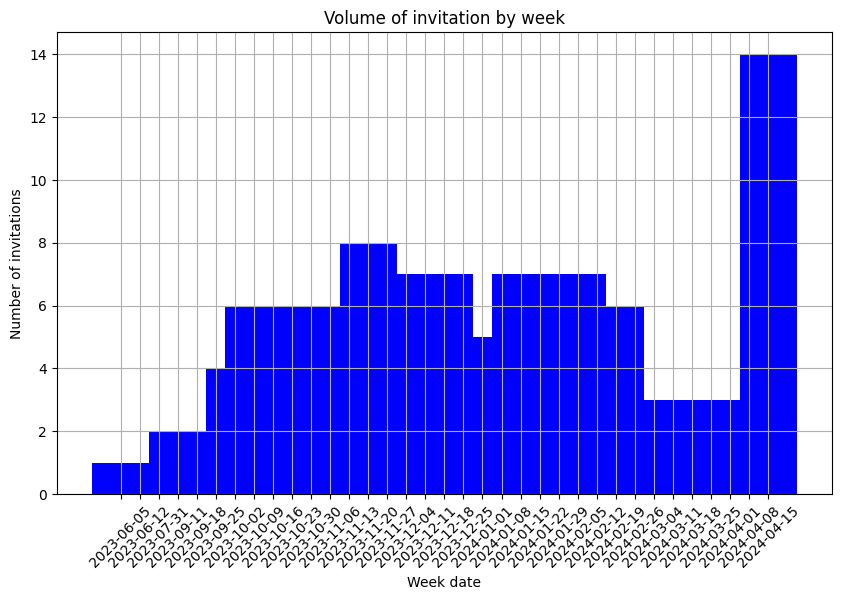

In [87]:
# Invitation volume evolution

# Aggregation by week
df_inv_by_week = df_invitations.groupby(['date_week'], as_index=False, dropna=False).agg({'inviter':'count'})

#Rename columns
df_inv_by_week.columns = ['date_week', 'invitation_ct']

# Histogram creation
plt.figure(figsize=(10, 6)) 
plt.bar(df_inv_by_week['date_week'].dt.strftime('%Y-%m-%d'), df_inv_by_week['invitation_ct'], color='blue', width=3) 
plt.title('Volume of invitation by week')
plt.xlabel('Week date')
plt.ylabel('Number of invitations')
plt.xticks(rotation=45)
plt.grid(True)  
plt.show() 


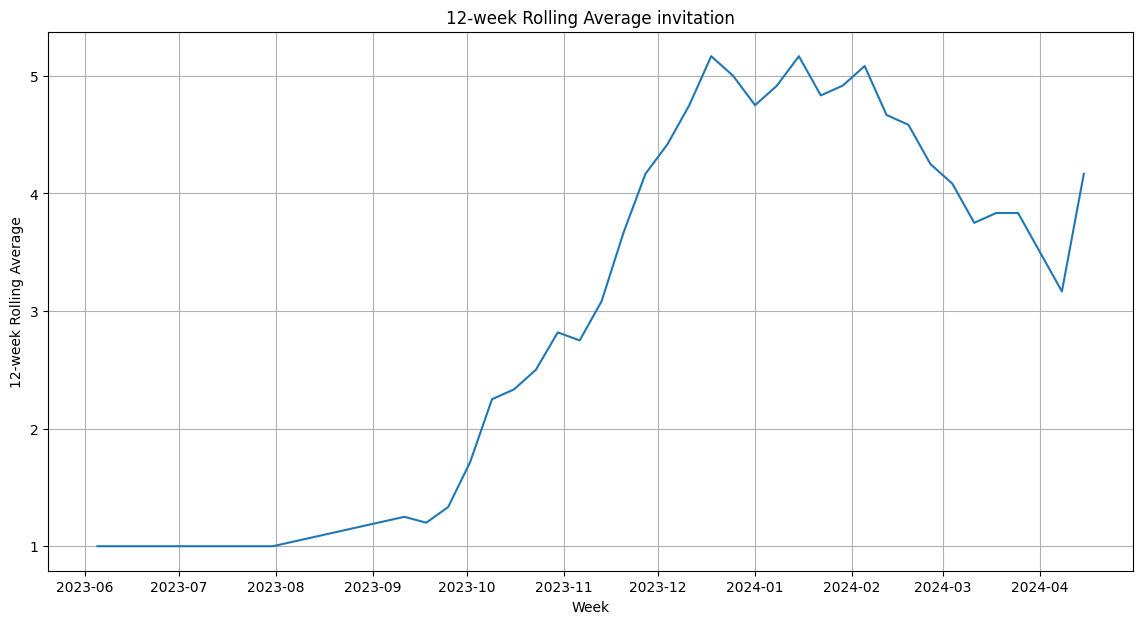

In [88]:
# Rolling 12-week average

# Calculating the rolling 16-week average
df_inv_by_week['rolling_average'] = df_inv_by_week['invitation_ct'].rolling(window=12, min_periods=1).mean()

# Line plot creation
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_inv_by_week, x='date_week', y='rolling_average')
plt.title('12-week Rolling Average invitation')
plt.xlabel('Week')
plt.ylabel('12-week Rolling Average')
plt.grid(True)
plt.show()

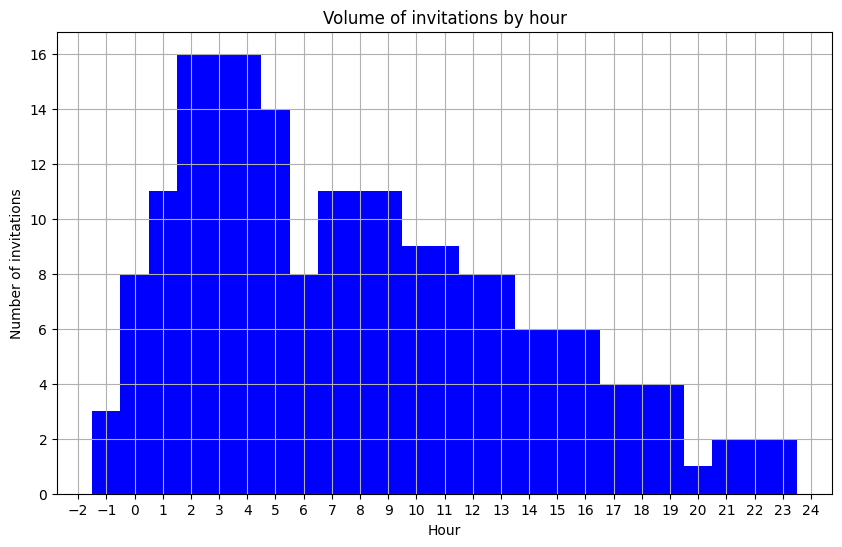

In [89]:
# Distribution of invitations by time of day

# Aggregation by week
df_inv_by_hour = df_invitations.groupby(['sent_at_hour'], as_index=False, dropna=False).agg({'inviter':'count'})

#Rename columns
df_inv_by_hour.columns = ['hour', 'invitation_ct']

# Sort values
df_inv_by_hour = df_inv_by_hour.sort_values(by=['hour'])

# Histogram creation
plt.figure(figsize=(10, 6)) 
plt.bar(df_inv_by_hour['hour'], df_inv_by_hour['invitation_ct'], color='blue', width=3)  
plt.gca().xaxis.set_major_locator(MultipleLocator(1)) 
plt.title('Volume of invitations by hour')
plt.xlabel('Hour')
plt.ylabel('Number of invitations')
plt.grid(True)  
plt.show() 



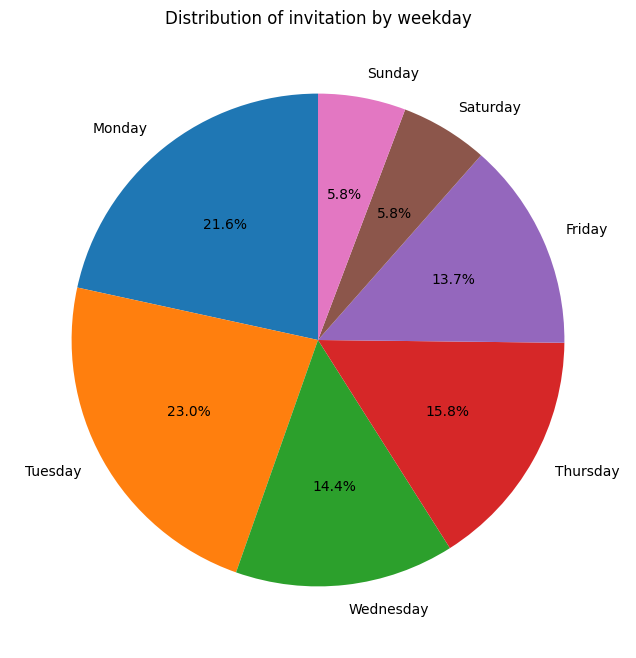

In [91]:
# Distribution of invitations by weekday

# Aggregation by week
df_inv_by_weekday = df_invitations.groupby(['day_of_week'], as_index=False, dropna=False).agg({'inviter':'count'})

#Rename columns
df_inv_by_weekday.columns = ['day_of_week', 'invitation_ct']

# Define the correct order of the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Rearrange DataFrame according to day order
df_inv_by_weekday['day_of_week'] = pd.Categorical(df_inv_by_weekday['day_of_week'], categories=days_order, ordered=True)
df_inv_by_weekday = df_inv_by_weekday.sort_values('day_of_week')

# Pie chart creation
plt.figure(figsize=(8, 8))  # Définit la taille de la figure
plt.pie(df_inv_by_weekday['invitation_ct'], labels=df_inv_by_weekday['day_of_week'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of invitation by weekday')
plt.show()

#### All likes

In [93]:
#volume de like dans le temps
#jour de la semaine avec le plus de like
#heure de la journée avec le plus de like


df_all_likes.dtypes

link         object
date         object
type         object
date_hour     int64
dtype: object

In [95]:
# Week likes date
df_all_likes['date'] = pd.to_datetime(df_all_likes['date'])
df_all_likes['date_week'] = df_all_likes['date'].dt.to_period('W').apply(lambda x: x.start_time)

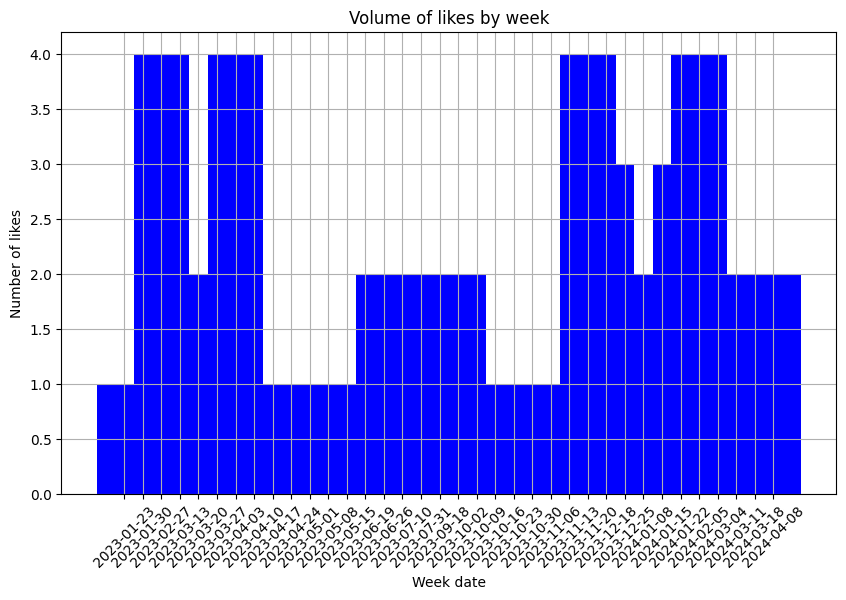

In [97]:
# Likes volume evolution

# Aggregation by week
df_likes_by_week = df_all_likes.groupby(['date_week'], as_index=False, dropna=False).agg({'link':'count'})
df_likes_by_week = df_likes_by_week[df_likes_by_week['date_week'] >= '2023-01-01']

#Rename columns
df_likes_by_week.columns = ['date_week', 'like_ct']

# Histogram creation
plt.figure(figsize=(10, 6)) 
plt.bar(df_likes_by_week['date_week'].dt.strftime('%Y-%m-%d'), df_likes_by_week['like_ct'], color='blue', width=3) 
plt.title('Volume of likes by week')
plt.xlabel('Week date')
plt.ylabel('Number of likes')
plt.xticks(rotation=45)
plt.grid(True)  
plt.show() 
